In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

In [4]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [5]:
from solver import deasolver

In [6]:
results = []
df_imp = pd.DataFrame()

In [8]:
df = pd.read_excel("Data/RealData/jmse_37_Data_V3 copy 2.xlsx", index_col = 0)

In [9]:
df.head()

,Input_owners’ equity,Input_total operational expences,Output_net profit
1,1.355335e+09,4.813198e+08,1.169624e+08
2,6.172486e+09,1.468911e+09,5.305416e+08
3,8.134738e+09,6.379069e+09,4.194821e+08
4,2.222073e+09,1.128459e+09,3.893530e+07
5,1.830483e+09,4.110728e+09,4.720929e+08


In [10]:
deasolver(inputfile="Data/RealData/jmse_37_Data_V3 copy 2.xlsx", folder = "Data/RealData/", out_suffix1="_Sol")

Restricted license - for non-production use only - expires 2023-10-25


Restricted license - for non-production use only - expires 2023-10-25


100.0
Solution file saved outputfile


In [11]:
df_weights = pd.read_excel("Data/RealData/jmse_37_Data_V3 copy 2_Sol.xlsx", index_col = 0).iloc[:, 1:]
df_weights

,Weight_Input_owners’ equity,Weight_Input_total operational expences,Weight_Output_net profit
1,5.061098e-10,6.524802e-10,2.048413e-09
2,1.239739e-10,1.598279e-10,5.017678e-10
3,1.240909e-10,-1.480934e-12,2.704173e-10
4,2.719689e-10,3.506242e-10,1.100758e-09
5,5.613486e-10,-6.699282e-12,1.223283e-09
...,...,...,...
944,6.173378e-11,-7.367473e-13,1.345294e-10
945,1.065596e-10,1.373774e-10,4.312859e-10
946,7.682075e-10,0.000000e+00,1.687231e-09
947,7.494201e-10,0.000000e+00,1.645968e-09


In [12]:
(df_weights["Weight_Input_total operational expences"]<df_weights["Weight_Input_owners’ equity"]).sum()

558

In [13]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input_owners’ equity                  3
Weight_Input_total operational expences    327
Weight_Output_net profit\n                  64
dtype: int64

### ML

In [14]:
X = df.iloc[:,:-1]
X.head()

,Input_owners’ equity,Input_total operational expences
1,1.355335e+09,4.813198e+08
2,6.172486e+09,1.468911e+09
3,8.134738e+09,6.379069e+09
4,2.222073e+09,1.128459e+09
5,1.830483e+09,4.110728e+09


In [15]:
y = df.iloc[:,-1:]
y.head()

,Output_net profit
1,1.169624e+08
2,5.305416e+08
3,4.194821e+08
4,3.893530e+07
5,4.720929e+08


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [18]:
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -2.0505002528276308e+18
neg_root_mean_squared_error: -1058032615.6649258
r2: 0.32145017793717884


In [19]:
learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

In [20]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [21]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=1)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   param_distributions={'gradientboostingregressor__learning_rate': [1,
                                                                                     0.5,
                                                                                     0.1,
                                                                                     0.01],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 10,
                                                                 

In [22]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-1015569105.5450783
{'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 2000, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': None, 'gradientboostingregressor__learning_rate': 0.1}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=None, n_estimators=2000,
                                           random_state=42, subsample=0.3))])
r2: 0.20246848558986114


In [23]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

array([0.66, 0.34])

In [24]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

,Feature Name,Importance
0,Input_owners’ equity,0.660968
1,Input_total operational expences,0.339032


In [25]:
input_imp = list(df_gb["Feature Name"].values)
results.append((0, grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

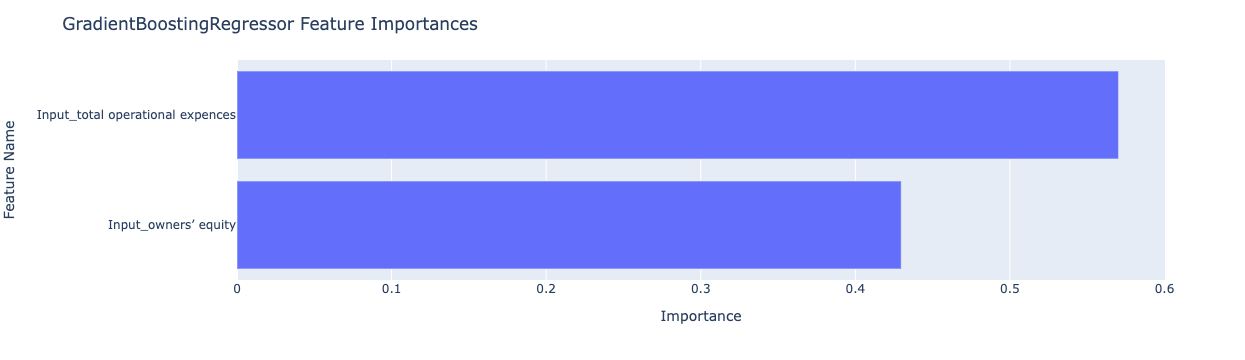

In [26]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=600,
    height=300,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [27]:
df_gb

,Feature Name,Importance
1,Input_total operational expences,0.570309
0,Input_owners’ equity,0.429691


In [28]:
df_zero.index = ["_".join(f.split("_")[1:]) for f in df_zero.index]

In [29]:
df_zero

Input_owners’ equity                9
Input_total operational expences    0
Output_operational income           0
dtype: int64

In [30]:
df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Input_total operational expences,0.570309,Input_total operational expences,0
1,Input_owners’ equity,0.429691,Input_owners’ equity,9


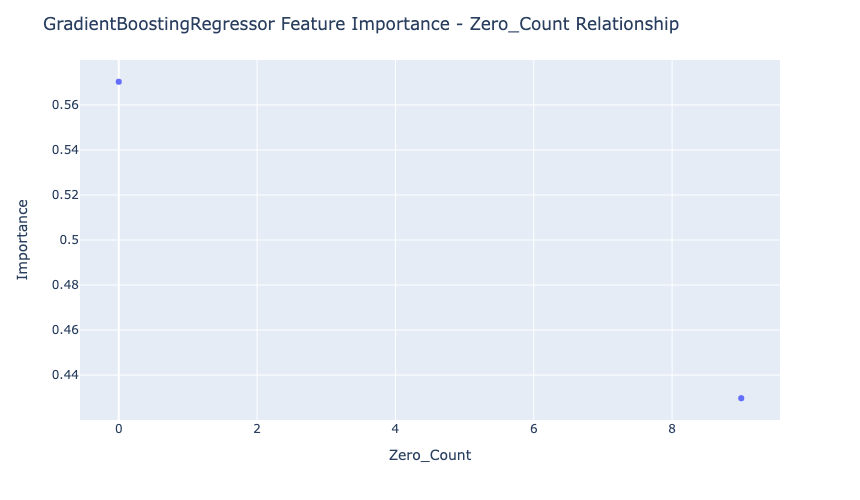

In [31]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

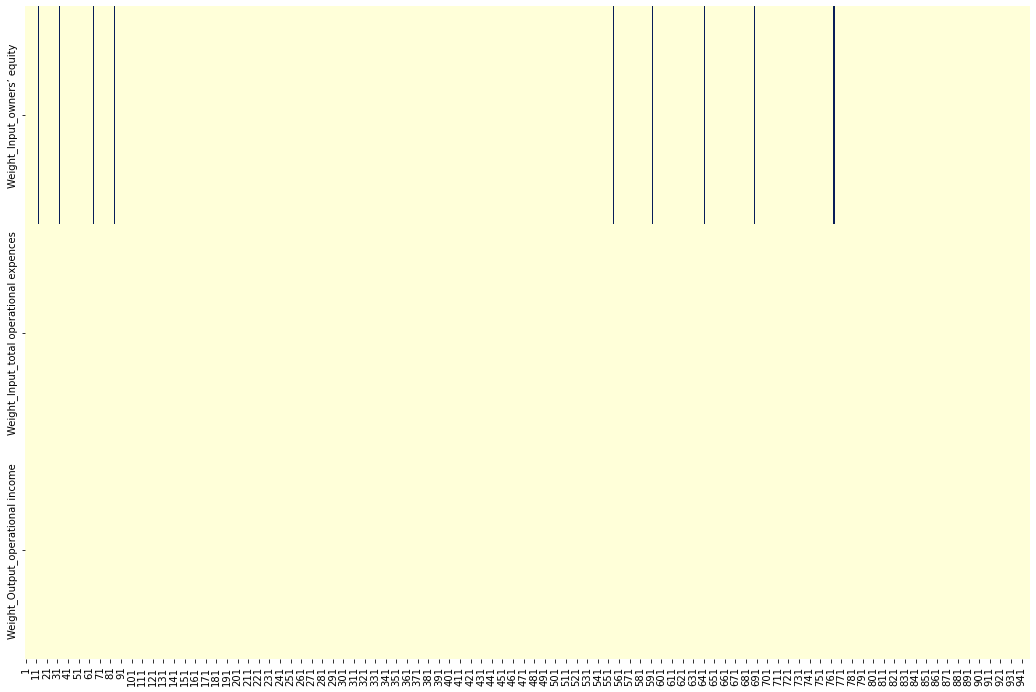

In [32]:
plt.figure(figsize=(18,12))
sns.heatmap(df_weights.eq(0).transpose(),
        cmap="YlGnBu",
        cbar=False,
        cbar_kws={'label': 'Zero Values'});

In [33]:
results 

[(0,
  'gradientboostingregressor',
  ['Input_total operational expences', 'Input_owners’ equity'],
  {'r2': 0.8746676244853525,
   'neg_root_mean_squared_error': -16508678336.787369})]

In [34]:
results[0]

(0,
 'gradientboostingregressor',
 ['Input_total operational expences', 'Input_owners’ equity'],
 {'r2': 0.8746676244853525,
  'neg_root_mean_squared_error': -16508678336.787369})

In [35]:
deasolver(inputfile="Data/RealData/jmse_37_Data_V3 copy.xlsx", folder = "Data/RealData/", out_suffix1="_Sol_1", input_imp = results[0])

100.0
Solution file saved outputfile


In [36]:
df_weights_1 = pd.read_excel("Data/RealData/jmse_37_Data_V3 copy_Sol_1.xlsx", index_col = 0).iloc[:, 1:]
df_weights_1

,Weight_Input_owners’ equity,Weight_Input_total operational expences,Weight_Output_operational income
1,2.098147e-10,1.486809e-09,9.997268e-10
2,6.030770e-11,4.273583e-10,2.873546e-10
3,5.082656e-11,9.194747e-11,9.384525e-11
4,9.786008e-11,6.934656e-10,4.662845e-10
5,1.079102e-10,1.952142e-10,1.992434e-10
...,...,...,...
944,1.660336e-11,3.003620e-11,3.065614e-11
945,4.079441e-11,2.890813e-10,1.943775e-10
946,1.020711e-10,1.846511e-10,1.884622e-10
947,1.335873e-10,2.416652e-10,2.466531e-10


In [37]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input_owners’ equity                9
Weight_Input_total operational expences    0
Weight_Output_operational income           0
dtype: int64

In [38]:
df_es = pd.read_excel("Data/RealData/jmse_37_Data_V3 copy_Sol.xlsx", index_col = 0).iloc[:, :1]
df_es_1 = pd.read_excel("Data/RealData/jmse_37_Data_V3 copy_Sol_1.xlsx", index_col = 0).iloc[:, :1]

In [39]:
es = (df_es.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es}")

count of efficient units : 1


In [40]:
es_1 = (df_es_1.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es_1}")

count of efficient units : 1


In [47]:
(df_weights["Weight_Input_total operational expences"]<df_weights["Weight_Input_owners’ equity"]).sum()

0